# Preprocessing

## The dataset

In [5]:
import pandas as pd

data = pd.read_csv("../CSVs Cleaned/Cleaned cleaned_all_phones.csv")
print(data.head())
y = data['price']

    brand           os  inches  battery battery_type  ram(GB)  \
0  Huawei  Android 5.1     5.0     2200        Li-Po        2   
1      LG  Android 7.0     5.3     2700       Li-Ion        2   
2  Huawei  Android 7.0     5.2     3000       Li-Ion        4   
3  Xiaomi  Android 6.0     5.5     4100        Li-Po        4   
4  Huawei  Android 7.0     5.1     3200       Li-Ion        4   

  announcement_date  weight(g)  storage(GB)  video_720p  ...  video_120fps  \
0        2016-09-01      140.0           16        True  ...         False   
1        2016-12-01      140.0           16       False  ...         False   
2        2017-01-01      147.0           16       False  ...         False   
3        2017-01-01      165.0           32        True  ...          True   
4        2017-02-01      145.0           32        True  ...         False   

   video_240fps  video_480fps  video_960fps  price  resolution_height  \
0         False         False         False  120.0                7

Using TargetEncoder to encode categorical features

In [ ]:
from sklearn.preprocessing import TargetEncoder
from datetime import datetime
encoder = TargetEncoder(target_type="continuous")
data['brand_encoded'] = encoder.fit_transform(data[['brand']], y)
data['battery_type_encoded'] = encoder.fit_transform(data[['battery_type']], y)
data['os_encoded'] = encoder.fit_transform(data[['os']], y)

for col in data:
  if col.find('video') != -1:
    # data[f'{col}_encoded'] = encoder.fit_transform(data[[col]], y)
    data.drop(col, axis=1, inplace=True)

data['announcement_date'] = data['announcement_date'].apply(lambda x: datetime.fromisoformat(x).timestamp())
del data['brand']
del data['battery_type']
del data['os']
del data['os_brands']
del data['resolution_height']
del data['resolution_width']

print(data.head())

KeyError: 'os_unique'

Drop samples with empty columns and separate features from target feature, price. Then select the top 10 features based on their mutual information (nat) score.

In [ ]:
from sklearn.feature_selection import mutual_info_regression, SelectKBest
data = data.dropna()

y = data['price']
# dollars = []
# for price in y:
#     dollars.append(int(price) / 100)
# y = pd.DataFrame(dollars)
X = data.drop('price', axis=1)

mutual_info = mutual_info_regression(X, y)

# Create a DataFrame for better visualization
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Score': mutual_info,
}).sort_values(by='Score', ascending=False)

# Display the feature importance scores
print(feature_scores)

select = SelectKBest(mutual_info_regression, k=10).fit(X, y)
X = select.transform(X)
print(f"\nSelected Features: {select.get_feature_names_out()}")

                 Feature     Score
2                ram(GB)  0.138292
7                    ppi  0.137218
6             resolution  0.130065
5            storage(GB)  0.115295
3      announcement_date  0.087307
1                battery  0.072215
0                 inches  0.070185
8          brand_encoded  0.054779
4              weight(g)  0.048879
10            os_encoded  0.035042
9   battery_type_encoded  0.007400

Selected Features: ['inches' 'battery' 'ram(GB)' 'announcement_date' 'weight(g)'
 'storage(GB)' 'resolution' 'ppi' 'brand_encoded' 'os_encoded']


# Training and testing

Scaling features

In [ ]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
scaled_X = sc_X.fit_transform(X)
scaled_y = sc_y.fit_transform(y.to_numpy().reshape(-1, 1))

Split the dataset into test data and training data

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_X, scaled_y, test_size=0.1)

Fit the training data to the model, and test by performing predictions on the test data

In [ ]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor.fit(X_train, y_train)

pred = regressor.predict(X_test)
pred = pd.DataFrame(pred)

# Revert scaled values to price information
predicted_price = sc_y.inverse_transform(pred)
real_price = sc_y.inverse_transform(y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Summarize performance

Train accuracy: 0.34055871980095054
Test accuracy: 0.06222046523195268
MAE: $84.29999356360584
MAPE: 0.3173447143352986


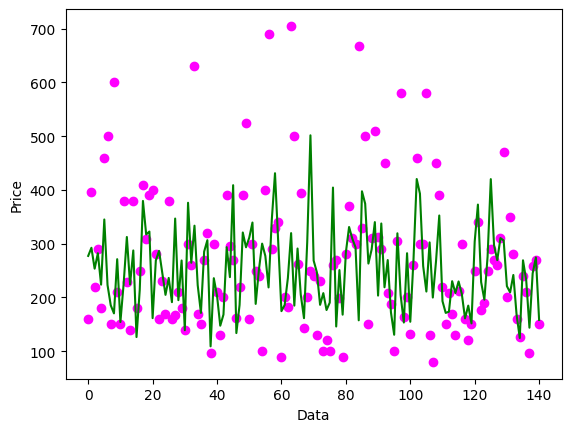

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

print(f"Train accuracy: {regressor.score(X_train, y_train)}")
print(f"Test accuracy: {regressor.score(X_test, y_test)}")
print(f"MAE: ${mean_absolute_error(real_price, predicted_price)}")
print(f"MAPE: {mean_absolute_percentage_error(real_price, predicted_price)}")

import matplotlib.pyplot as plt
graph_points = len(y_test)
plt.scatter(range(graph_points), real_price[:graph_points], color = 'magenta')
plt.plot(range(graph_points), predicted_price[:graph_points], color = 'green')
plt.xlabel('Data')
plt.ylabel('Price')
plt.show()

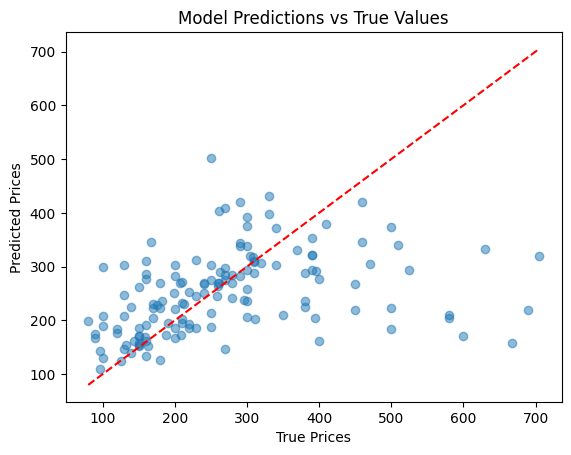

In [ ]:
plt.scatter(real_price, predicted_price, alpha=0.5)
plt.plot([min(real_price), max(real_price)], [min(real_price), max(real_price)], 'r--')
plt.xlabel("True Prices")
plt.ylabel("Predicted Prices")
plt.title("Model Predictions vs True Values")
plt.show()